In [32]:
import pandas as pd 
import numpy as np
df = pd.read_excel("./data/spy_data.xlsx", sheet_name = 'total returns')
df = df.set_index('date')
df['Excess_SPY'] = df['SPY'] - df['^IRX']
df

,SPY,^IRX,Excess_SPY
date,,,
1994-01-04,0.004035,0.000122,0.003913
1994-01-05,0.002009,0.000122,0.001888
1994-01-06,0.000000,0.000121,-0.000121
1994-01-07,0.006016,0.000119,0.005897
1994-01-10,0.011960,0.000119,0.011841
...,...,...,...
2024-07-29,0.000588,0.000204,0.000384
2024-07-30,-0.005066,0.000204,-0.005270
2024-07-31,0.016255,0.000204,0.016051


<Axes: xlabel='date'>

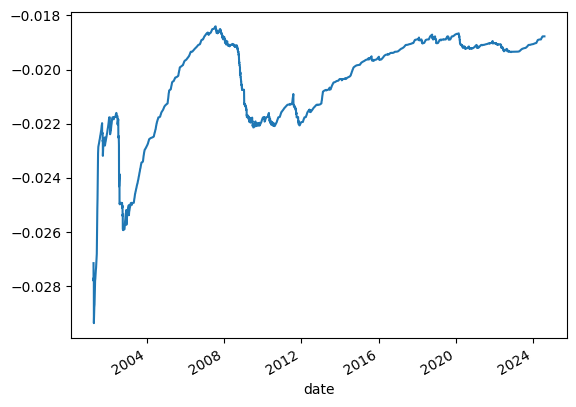

In [101]:
start = '2000-12-29'
quantile = 0.05
window = 60
data = df.loc[(df.index >= start)]['Excess_SPY']
historic_VaR = data.shift().expanding(window).quantile(quantile)
historic_VaR.plot()

In [40]:
difference = np.where(historic_VaR > data, 1, 0)
pd.Series(difference).value_counts()

0    5696
1     232
Name: count, dtype: int64

In [42]:
difference.sum()/len(difference)*100

3.913630229419703

Drawbacks of Historic VaR 


Drawbacks of Historic cVaR


/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_1622/3740525921.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if pd.notnull(returns_shifted[i]):  # Check for non-NaN value
/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_1622/3740525921.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ewma_vol[i] = theta * ewma_vol[i-1] + (1 - theta) * (returns_shifted[i] ** 2)


<Axes: xlabel='date'>

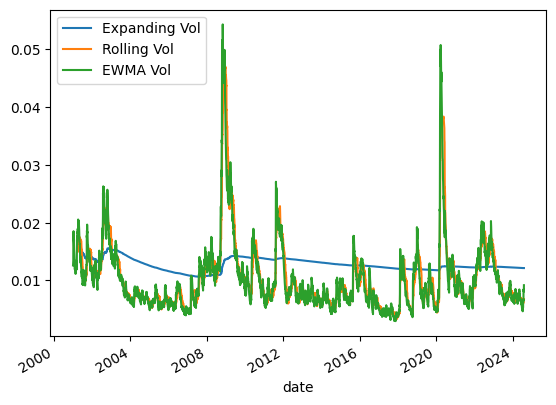

In [62]:
m = 252

def calc_vol(returns: pd.DataFrame, m: float): 

    expanding_vol = np.sqrt((returns**2).expanding(window).mean().shift())
    rolling_vol = np.sqrt((returns**2).rolling(window).mean().shift())

    ewma_vol = [0] * len(rolling_vol)
    theta = 0.94 
    sigma_0 = 0.20 / np.sqrt(m)
    ewma_vol[0] = sigma_0 ** 2  # initial variance
    returns_shifted = returns.shift()  # shift returns
    
    # Loop to calculate EWMA variance
    for i in range(1, len(ewma_vol)): 
        if pd.notnull(returns_shifted[i]):  # Check for non-NaN value
            ewma_vol[i] = theta * ewma_vol[i-1] + (1 - theta) * (returns_shifted[i] ** 2)
    
    # Convert the list to numpy array and take square root for volatility
    ewma_vol = np.sqrt(np.array(ewma_vol))
    vol_df = pd.DataFrame({
        'Expanding Vol': expanding_vol, 
        'Rolling Vol': rolling_vol, 
        'EWMA Vol': ewma_vol
    })

    z_score = -1.65 
    vol_df_z = vol_df * z_score 
    
    return vol_df, vol_df_z

vol_df, vol_df_z = calc_vol(data, m)

vol_df.plot()



In [63]:
vol_df * (-1.65)

,Expanding Vol,Rolling Vol,EWMA Vol
date,,,
2000-12-29,NaN,NaN,-0.020788
2001-01-02,NaN,NaN,-0.021591
2001-01-03,NaN,NaN,-0.022205
2001-01-04,NaN,NaN,-0.028930
2001-01-05,NaN,NaN,-0.028397
...,...,...,...
2024-07-29,-0.020037,-0.010906,-0.013951
2024-07-30,-0.020036,-0.010882,-0.013527
2024-07-31,-0.020034,-0.010765,-0.013286


In [64]:
vol_df_z

,Expanding Vol,Rolling Vol,EWMA Vol
date,,,
2000-12-29,NaN,NaN,-0.020788
2001-01-02,NaN,NaN,-0.021591
2001-01-03,NaN,NaN,-0.022205
2001-01-04,NaN,NaN,-0.028930
2001-01-05,NaN,NaN,-0.028397
...,...,...,...
2024-07-29,-0.020037,-0.010906,-0.013951
2024-07-30,-0.020036,-0.010882,-0.013527
2024-07-31,-0.020034,-0.010765,-0.013286


<Axes: xlabel='date'>

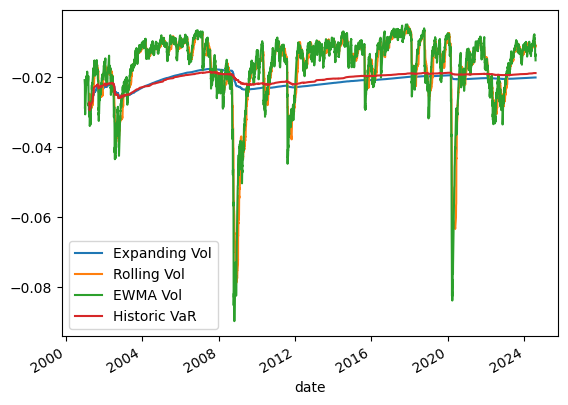

In [65]:
vol_df_z['Historic VaR'] =  historic_VaR
vol_df_z.plot()

In [95]:
vol_df_z['returns'] = df['Excess_SPY']
vol_df_z = vol_df_z.dropna()
cols = list(vol_df_z.columns) 
var_periods_df = vol_df_z.copy().drop(columns = ['returns'])
frequency_df = pd.DataFrame(index = var_periods_df.columns, columns = ['Frequency (%)'])
for col in cols: 
    if col == 'returns': 
        continue 
    var_periods_df[col] = np.where(var_periods_df[col] > vol_df_z['returns'], 1, 0)
    frequency = var_periods_df[col].value_counts()
    frequency_df.loc[col, 'Frequency (%)'] = (frequency[1]/len(var_periods_df[col])) * 100
    
frequency_df

,Frequency (%)
Expanding Vol,3.646898
Rolling Vol,5.998637
EWMA Vol,5.947512
Historic VaR,3.953647


How do each compare with each other 

In [103]:
# cvar 
historic_VaR = data.shift().expanding(window).quantile(quantile)
historic_cVaR = []

# Calculate historic CVaR by averaging values below the historic VaR
for i in range(1, len(data)):
    current_window = data.shift().iloc[:i]  # Expanding window up to the current index
    var_at_i = historic_VaR.iloc[i]         # Historic VaR at the current index
    cvar_at_i = current_window[current_window < var_at_i].mean()  # Mean of values below VaR
    historic_cVaR.append(cvar_at_i)

# alternative: # Calculate CVaR using an expanding window, starting with a minimum of 60 data points
# CVaR['Historic'] = rets.expanding(60).apply(lambda x: x[x < x.quantile(0.05)].mean(), raw=True)


# Convert the CVaR list to a pandas Series
historic_cVaR = pd.Series(historic_cVaR, index=data.index[1:])

# Output the historic CVaR
historic_cVaR

date
2001-01-02         NaN
2001-01-03         NaN
2001-01-04         NaN
2001-01-05         NaN
2001-01-08         NaN
                ...   
2024-07-29   -0.029302
2024-07-30   -0.029302
2024-07-31   -0.029302
2024-08-01   -0.029302
2024-08-02   -0.029302
Length: 5927, dtype: float64

In [104]:
vol_df_z


,Expanding Vol,Rolling Vol,EWMA Vol,Historic VaR,returns
date,,,,,
2001-03-28,-0.026536,-0.026536,-0.030084,-0.027153,-0.027807
2001-03-29,-0.026966,-0.026882,-0.031258,-0.027807,0.003658
2001-03-30,-0.026758,-0.026608,-0.030341,-0.027768,0.010312
2001-04-02,-0.026632,-0.024679,-0.029711,-0.027728,-0.021503
2001-04-03,-0.026792,-0.024992,-0.030088,-0.027689,-0.033523
...,...,...,...,...,...
2024-07-29,-0.020037,-0.010906,-0.013951,-0.018775,0.000384
2024-07-30,-0.020036,-0.010882,-0.013527,-0.018775,-0.005270
2024-07-31,-0.020034,-0.010765,-0.013286,-0.018775,0.016051
